In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load the dataset
df = pd.read_csv('Disease_train.csv')

# Display the class distribution
print(df['diagnosis'].value_counts())

# Separate majority and minority classes
df_majority = df[df.diagnosis == 0]
df_minority = df[df.diagnosis == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled['diagnosis'].value_counts())

# Save the balanced dataset to a new CSV file
df_upsampled.to_csv('Disease_train_balanced.csv', index=False)
print('Balanced dataset saved to Disease_train_balanced.csv')

diagnosis
0    3804
1     196
Name: count, dtype: int64
diagnosis
0    3804
1    3804
Name: count, dtype: int64
Balanced dataset saved to Disease_train_balanced.csv


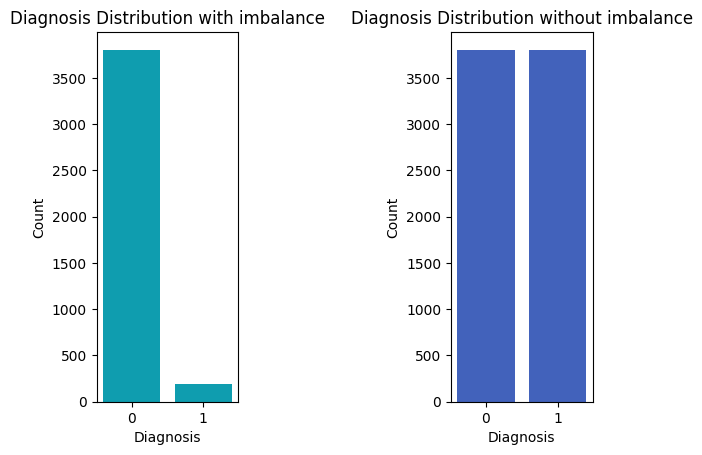

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)

ax[0].bar(df['diagnosis'].value_counts().index, df['diagnosis'].value_counts().values, color='#0F9DAF')
ax[0].set_xlabel('Diagnosis')
ax[0].set_ylabel('Count')
ax[0].set_title('Diagnosis Distribution with imbalance')

ax[1].bar(df_upsampled['diagnosis'].value_counts().index, df_upsampled['diagnosis'].value_counts().values, color='#4262BB')
ax[1].set_xlabel('Diagnosis')
ax[1].set_ylabel('Count')
ax[1].set_title('Diagnosis Distribution without imbalance')

plt.subplots_adjust(wspace=1.5)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import joblib
import numpy as np

# Load the dataset
df = pd.read_csv('Disease_train_balanced.csv')

# Display the first few rows of the dataframe
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Handle missing values (if any)
df.fillna(df.mean(), inplace=True)

# Separate features and target variable
X = df.drop(columns=['patient_id', 'diagnosis'])
y = df['diagnosis']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the model on the validation set
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print('Best Hyperparameters:', grid_search.best_params_)
print('Validation Accuracy:', accuracy)
print('Validation ROC AUC Score:', roc_auc)

# Save the trained model and scaler to a file
joblib.dump(best_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.374540   0.950714   0.731994   0.598658   0.156019   0.155995   
1   0.020584   0.969910   0.832443   0.212339   0.181825   0.183405   
2   0.611853   0.139494   0.292145   0.366362   0.456070   0.785176   
3   0.388677   0.271349   0.828738   0.356753   0.280935   0.542696   
4   0.772245   0.198716   0.005522   0.815461   0.706857   0.729007   

   feature_7  feature_8  feature_9  feature_10  patient_id  diagnosis  
0   0.058084   0.866176   0.601115    0.708073           1          0  
1   0.304242   0.524756   0.431945    0.291229           2          0  
2   0.199674   0.514234   0.592415    0.046450           3          0  
3   0.140924   0.802197   0.074551    0.986887           7          0  
4   0.771270   0.074045   0.358466    0.115869           8          0  
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9    

['scaler.pkl']

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load the test data
test_df = pd.read_csv('Disease_test.csv')

# Assuming 'patient_id' is a column in your test data
# Separate the features (excluding 'patient_id')
X_test = test_df.drop(columns=['patient_id'])

# Load the trained model and scaler
best_xgb = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Predict the target variable using the trained model
y_pred = best_xgb.predict(X_test_scaled)

# Add the predictions as a new column to the test DataFrame
test_df['prediction'] = y_pred

# Keep the 'patient_id' and 'prediction' columns only
test_df = test_df[['patient_id', 'prediction']]

# Save the DataFrame with predictions to a new CSV file
test_df.to_csv('SE22UCSE076_predictions.csv', index=False)

print('Predictions saved')


Predictions saved
